# Avito: O que é? 

# Importando libs

In [3]:
%matplotlib inline  
import numpy as np
import pandas as pd
import scipy as sp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Carregando o dataset

In [4]:
df_simple = pd.read_csv('train.csv.zip', compression='zip')

## Tratamento dos dados

In [5]:
# transformando descrições nulas em str vazias
df_simple['description'] = df_simple['description'].replace(np.nan, '', regex=True)


In [6]:

# trocando para que colunas com valores em russo sejam substituidas por valores de 0-N
# acho q isso vai facilitar na hora de acessar essas colunas
# ao inves de tentar pegar pelos diferentes valores de cada uma
def convert_columns_with_russian_values_to_numbers(df, cols):
    transform_dict = {}
    for col in cols:
        cats = pd.Categorical(df[col]).categories
        d = {}
        for i, cat in enumerate(cats):
            d[cat] = f'{i}'
        transform_dict[col] = d
    inverse_transform_dict = {}
    for col, d in transform_dict.items():
        inverse_transform_dict[col] = {v:k for k, v in d.items()}
        
    return df.replace(transform_dict), inverse_transform_dict
# Aplica essa função para category_name e region
df, inverse_transform_dict = convert_columns_with_russian_values_to_numbers(df_simple, ['category_name', 'region'])

# transforma user_type e category_name em diferentes colunas com representações one-hot delas
df = pd.get_dummies(df, columns=['user_type','category_name', ])


In [7]:
# add deal_prob_class (low, average ou high)

def convert_deal_probability_to_class(value):
    classes = [

    ]
    if value * 100 <= (100 / 3 * 1):
        return 'low'
    elif value * 100 <= (100 / 3 * 2):
        return 'average'
    else:
        return 'high'

df['deal_prob_class'] = df['deal_probability'].apply(convert_deal_probability_to_class)

## Train-test split (com amostra)

In [8]:
# train_frac == 0.34 ~= 510000 ~= total de exemplos no test_csv.zip
def get_train_test_samples(df, seed, train_frac=0.34): 
    train_dfs = []
    test_dfs = []
    for klass in ['low', 'average', 'high']:
        klass_df = df[df['deal_prob_class'] == klass]
        klass_train, klass_test = train_test_split(klass_df,  test_size=(1-train_frac), random_state=seed)
        train_dfs.append(klass_train)
        test_dfs.append(klass_test)
        
    train_df = pd.concat(train_dfs, ignore_index=True)
    test_df = pd.concat(test_dfs, ignore_index=True)
    return train_df, test_df

seed = np.random.RandomState(seed=123654)
train_df, test_df = get_train_test_samples(df, seed, train_frac=0.34)

511163

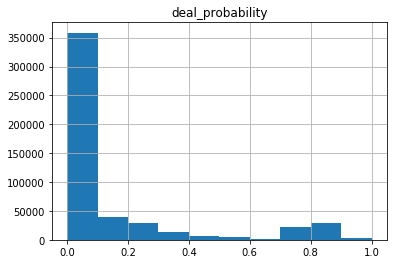

In [9]:
train_df.hist('deal_probability')
train_df.shape[0]

Comparando com o original:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcabb7079e8>]],
      dtype=object)

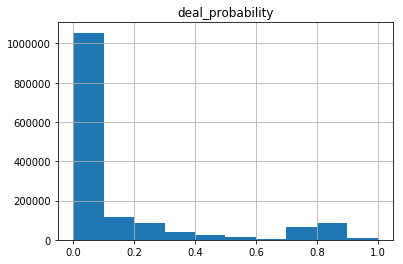

In [12]:
df.hist(column='deal_probability')

## Sobre os dados

* title
* description
* user_type
* price
* category_name
* item_seq_number
* region
* deal_probability


Uma olhada nos dados:

In [4]:
df.head(5)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


Agrupando pelas categorias

In [8]:
group_category = df_simple.groupby('category_name')
group_category.count().head(3)

,item_id,user_id,region,city,parent_category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
category_name,,,,,,,,,,,,,,,,,
Автомобили,62494,62494,62494,62494,62494,62055,62055,61937,62494,62494,61287,62494,62494,62494,58949,58949,62494
Аквариум,4840,4840,4840,4840,4840,0,0,0,4840,4504,4302,4840,4840,4840,4519,4519,4840
Аудио и видео,27036,27036,27036,27036,27036,26857,0,0,27036,24880,26186,27036,27036,27036,25893,25893,27036


Conferindo comportamento de items com preço 0
grande parte é proximo de 0
E alguns tmb são muito vendidos (vi que tem muitas coisas de troca, ou adoção de animal abandonado por exemplo)

(2369, 18)
(2277, 18)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f931a501588>]],
      dtype=object)

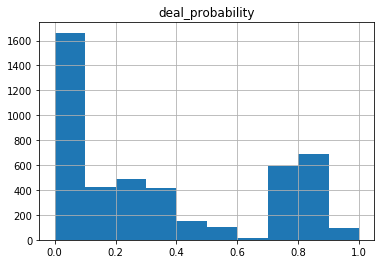

In [6]:
free_price = df[(df['price'] == 0)]
print(free_price[(free_price['deal_probability'] < 0.25)].shape)
print(free_price[(free_price['deal_probability'] >= 0.25)].shape)
free_price.hist(column='deal_probability')

## Visualizando a distribuiçã das probabilidades de venda

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f44380074a8>]],
      dtype=object)

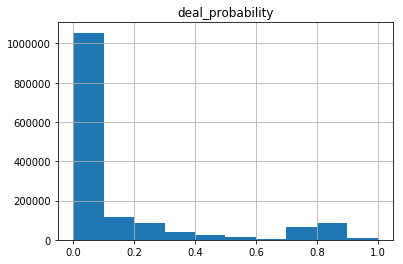

In [10]:
df.hist(column='deal_probability')

# Testando montar um bag of words

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def prepare_vectorizer_and_col(df, col_name):
    vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords.words('russian'))
    corpus = df[col_name]
    col_vectorized = vectorizer.fit_transform(corpus)
    return col_vectorized, vectorizer

    



[nltk_data] Downloading package stopwords to /home/arruda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
description_vectorized, vectorizer_description = prepare_vectorizer_and_col(df, 'description')

In [15]:
from sklearn.naive_bayes import MultinomialNB

def get_multinomial_NB(X, y):
    classifier = MultinomialNB()
    classifier.fit(X, y)
    return classifier


In [16]:
model_description_multinomial_nb = get_multinomial_NB(description_vectorized, df['deal_prob_class'])

## testando modelo LinearRegression

In [24]:
from sklearn.linear_model import LinearRegression

# clf.(description_vectorized, df['deal_probability'])
linear_regression = LinearRegression()
linear_regression.fit(description_vectorized, df['deal_probability'])
# clf.predict()


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [24]:
import pickle
def save_description_linear_regression_model(pkl_filename, model):
    with open(pkl_filename, 'wb') as f:
        pickle.dump(model, f)
def load_description_linear_regression_model(pkl_filename):
    with open(pkl_filename, 'rb') as f:
        pickle_model = pickle.load(f)
        return pickle_model

In [37]:
save_description_linear_regression_model('description_countvec_lreg_model.pkl', linear_regression)
description_countvec_lreg_model = load_description_linear_regression_model('description_countvec_lreg_model.pkl')

In [ ]:
testv = description_countvec_lreg_model.coef_ == linear_regression.coef_

### Testando o modelo em cima do proprio dataset de treino:

In [53]:
from sklearn.metrics import mean_squared_error
#Bobinho, testando em cima do proprio treino, e ainda assim ficou bem ruim
desc_countvec_lreg_predict = description_countvec_lreg_model.predict(description_vectorized)

mean_squared_error(df['deal_probability'], desc_countvec_lreg_predict)

0.0396135274399414

## Testando usando linear regression + o predict do modelo anterior

primeiro add essa predict do modelo anterior no dataset

In [57]:
df['desc_countvec_lreg_predict'] = desc_countvec_lreg_predict

Agora usar isso e 'user_type, price, category_name, item_seq_number, region' pra 
 fazer uma nova linear regression (só preciso normalizar primeiro e arrumar as colunas que são classes)

# Tudo de novo, mas usando train dataset

In [14]:
from rake_nltk import Rake

def return_description_reduced(df):
    # Uses stopwords for russian from NLTK, and all puntuation characters.
    r = Rake(language='russian')
    
    total = df['description'].shape[0]
    
    verbose_step_size = int(total/10)
    description_reduced = []
    for i, description in enumerate(df['description']):
        r.extract_keywords_from_text(description)
        phrases_and_scores = r.get_ranked_phrases_with_scores()    
        mean_score = np.mean([x[0] for x in phrases_and_scores])

        highest_phrases = [x[1] for x in phrases_and_scores if x[0] >= mean_score]
        reduced_description = ' '.join(highest_phrases)
        description_reduced.append(reduced_description)
        
        
        if i % verbose_step_size == 0:
            print(f'{int(i/total*100)}') 
        
    return description_reduced



[nltk_data] Downloading package stopwords to /home/arruda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def prepare_vectorizer_and_col(df, col_name):
    vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords.words('russian'))
    corpus = df[col_name]
    col_vectorized = vectorizer.fit_transform(corpus)
    return col_vectorized, vectorizer


In [11]:
train_df['description_reduced'] = return_description_reduced(train_df)

0.0


/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.09999941310306106
0.1999988262061221
0.2999982393091832
0.3999976524122442
0.4999970655153053
0.5999964786183664
0.6999958917214274
0.7999953048244884
0.8999947179275495
0.9999941310306106


In [15]:
description_vectorized, vectorizer_description = prepare_vectorizer_and_col(train_df, 'description_reduced')

In [16]:
test_df['description_reduced'] = return_description_reduced(test_df)

0.0


/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.09999989922006408
0.19999979844012816
0.29999969766019224
0.3999995968802563
0.4999994961003204
0.5999993953203845
0.6999992945404485
0.7999991937605127
0.8999990929805767
0.9999989922006408


In [18]:
description_vectorized_test = vectorizer_description.transform(test_df['description_reduced'])

## testando BayesianRidge

In [18]:
sample_indexes = np.random.choice(description_vectorized.shape[0], size=16000)
description_vectorized_small_sample = description_vectorized[sample_indexes].toarray()
description_vectorized_small_sample.shape

(16000, 237385)

Precisa de uma matriz densa, e nao uma sparse.

In [43]:
# from sklearn.linear_model import BayesianRidge
# clf = BayesianRidge()
# clf.fit(description_vectorized, df['deal_probability'])
# # clf.predict()


**Inviavel, não tem memoria que dê jeito**

## Regressão linear

In [18]:
from sklearn.linear_model import LinearRegression

try:
    desc_red_countvec_lreg_model = load_description_linear_regression_model(
        'description_reduced_countvec_lreg_model.pkl')
except:
    desc_red_countvec_lreg_model = LinearRegression(n_jobs=4)
    desc_red_countvec_lreg_model.fit(description_vectorized, train_df['deal_probability'])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

In [22]:
save_description_linear_regression_model(
    pkl_filename='description_reduced_countvec_lreg_model.pkl', 
    model=desc_red_countvec_lreg_model
)

In [89]:
print(mean_squared_error(test_df['deal_probability'], np.zeros(y_predic.shape)))
print(mean_squared_error(test_df['deal_probability'], y_treated))

0.08696623321357727
0.08882529653938122


In [90]:
prediction_test_df = pd.DataFrame(
    {'deal_probability': y_treated}, 
    index=test_df['item_id'])

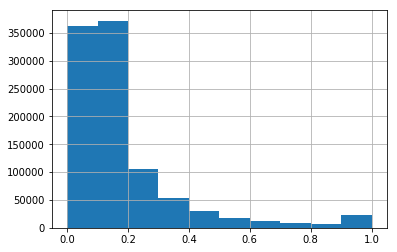

In [91]:
prediction_test_df['deal_probability'].hist()

## Using SVR

In [20]:
from sklearn.svm import SVR


In [22]:
try:
    description_reduced_countvec_svr_model = load_description_linear_regression_model(
        'description_reduced_countvec_svr_model.pkl')
except:
    description_reduced_countvec_svr_model = SVR(kernel='poly', verbose=True, cache_size=16000)     
    description_reduced_countvec_svr_model.fit(description_vectorized, train_df['deal_probability'])


In [29]:
save_description_linear_regression_model(
    pkl_filename='description_reduced_countvec_svr_model.pkl', 
    model=description_reduced_countvec_svr_model
)

In [27]:
y_predic = description_reduced_countvec_svr_model.predict(description_vectorized_test)
def limit_value(value):
    if value > 1:
        value = 1
    elif value < 0:
        value = 0
    return value
y_treated = np.array(list(map(limit_value, y_predic)))

In [28]:
print(mean_squared_error(test_df['deal_probability'], np.zeros(y_predic.shape)))
print(mean_squared_error(test_df['deal_probability'], y_treated))

0.08696623321357727
0.06911413911149261


# Running on test.csv for submission

In [32]:
submission_df = pd.read_csv('test.csv.zip', compression='zip')
submission_df['description'] = submission_df['description'].replace(np.nan, '', regex=True)

In [33]:
submission_df['description_reduced'] = return_description_reduced(submission_df)

0.0


/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arruda/.virtualenvs/icd_final-cXF_SA4B/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.09999842655348341
0.19999685310696683
0.29999527966045025
0.39999370621393365
0.49999213276741705
0.5999905593209005
0.6999889858743839
0.7999874124278673
0.8999858389813508
0.9999842655348341


In [34]:
description_vectorized_submission = vectorizer_description.transform(submission_df['description_reduced'])

### linear regression

In [46]:
y_predic = desc_red_countvec_lreg_model.predict(description_vectorized_submission)

### svr

In [35]:
y_predic = description_reduced_countvec_svr_model.predict(description_vectorized_submission)

### post-processing

In [53]:
min_y_predic = min(y_predic)
max_y_predic = max(y_predic)

y_predic_normalized = (y_predic-min_y_predic)/(max_y_predic-min_y_predic)

In [36]:
def limit_value(value):
    if value > 1:
        value = 1
    elif value < 0:
        value = 0
    return value
y_treated = np.array(list(map(limit_value, y_predic)))


In [40]:
submission_prediction_df = pd.DataFrame(
    {'deal_probability': y_predic}, 
    index=submission_df['item_id'])

In [41]:
submission_prediction_df.head()

,deal_probability
item_id,
6544e41a8817,0.100465
65b9484d670f,0.100465
8bab230b2ecd,0.100465
8e348601fefc,0.100465
8bd2fe400b89,0.100465


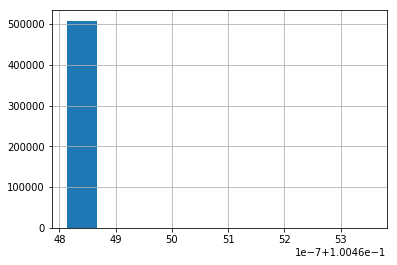

In [42]:
submission_prediction_df['deal_probability'].hist()

In [43]:
submission_prediction_df['deal_probability'].describe()

count    5.084380e+05
mean     1.004648e-01
std      1.544080e-09
min      1.004648e-01
25%      1.004648e-01
50%      1.004648e-01
75%      1.004648e-01
max      1.004654e-01
Name: deal_probability, dtype: float64

In [44]:
submission_prediction_df.to_csv('submission_svr.csv')